<a href="https://colab.research.google.com/github/wesleydecezere/programa_ds_fc/blob/master/4.%20Classifica%C3%A7%C3%A3o/Entrega%204%20-%20Classificacao/DS_Classifica%C3%A7%C3%A3o_FeatureEngineered.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Classificação</center>
___

## Conteúdo
1. [Recaptulação](#recap) <br>
2. [Definição do Problema](#problem_def) <br>
3. [Análise Inicial](#initial_analysis) <br>
4. [Split Treino e Teste](#split) <br>
5. [Modelagem](#modeling) <br>
6. [Avaliação dos Modelos](#eval) <br>
7. [Classificação Multiclasse](#multiclass) <br>
[Dig Deeper](#digdeeper)

<a id="recap"></a>
## 1. Recaptulação

Nas aulas anteriores, discutimos o que é Aprendizado de Máquina e como ele pode ser utilizado para resolver diferentes problemas, dando uma visão geral das diferentes classes de algoritmos, quais problemas cada um trata e as principais métricas para avaliá-los.

Nesta aula, focaremos em uma abordagem mais prática de como implementar e usar esses algoritimos em Python. Mais especificamente, exploraremos os principais algoritmos de classificação utilizados na indústria, como implementá-los usando a biblioteca ```scikit-learn```, como avaliá-los e selecionar o melhor para o problema em questão.

> **Relembrando**: **Classificação** é uma técnica de aprendizado de máquina supervisionado que usa um conhecimento adquirido de dados de treino para classificar novas observações dentre um conjunto finito de possíveis classes. Embora hajam mais variações, a classificação é separada usalmente entre dois tipos distintos: classificação binária, cujo objetivo é identificar amostras em duas classes distintas, e classificação multiclasse, em que há duas ou mais classes mutualmente excludentes.

<a id="problem_def"></a>
## 2. Definição do Problema

Uma grande aplicação de técnicas de classificação é ajudar no diagnóstico médico. O [uso de aprendizado de máquina no prognóstico de câncer e previsão](https://www.sciencedirect.com/science/article/pii/S2001037014000464) está virando crucial para abordar esse problema, visto que permite iniciar o tratamento apropriado o mais cedo possível e consequentemente aumentar a chance de sobrevivência do paciente.

Neste capítulo, vamos usar um dataset real incluso no ```scikit-learn```. O conjunto de dados público de câncer de mama de Wisconsin possui registros de medidas clínicas desses tumores. Eles são rotulados como tumores benignos e malignos e a tarefa consiste em aprender a **prever qual o seu tipo baseado nas medidas do tecido**.

Nós vamos construir e avaliar alguns modelos para esta tarefa, que consiste em uma classificação binária (apenas duas classes). Note, entretanto, que as técnicas discutidas a seguir podem facilmente ser extendidas para outros problemas de classificação binária ou então multiclasse.

Vamos começar importando o dataset e verificar sua descrição!

In [1]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

X, y = cancer.data, cancer.target

print("X", X.shape)
print("y", y.shape)

X (569, 30)
y (569,)


Datasets inclusos na biblioteca ```scikit-learn``` consistem em objetos *Bunch*, que contém os dados propriamente ditos mais diferentes informações adicionais sobre o conjunto de dados. Eles são similares a dicionários com o benefício adicional que você pode acessar seus valores usando uma sintaxe com pontos (dataset.label ao invés de dataset\['label'\]).

Para ver todas as informações em um objeto *Bunch*, utilize o método ```.keys()```.


In [2]:
# Printar a descrição do dataset
print(cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

<a id="initial_analysis"></a>
## 3. Análise Inicial

A maior parte dos conjuntos de dados disponíveis do ```scikit-learn``` são conhecidos como *toy datasets*, usados normalmente para propósitos educacionais e para realizar benchmarks de algoritmos. Portanto, eles geralmente possuem dados **limpos e tratados** para a modelagem. Porém, note que em qualquer problema ou conjunto de dados "real", as etapas de limpeza, preparação e engenharia de variáveis devem ser previamente realizadas.

Antes de começar a construir o modelo, existem algumas análises importantes e mais sutis que devem ser consideradas. Abaixo algumas delas:

### 3.1. Viés nos Dados
As vezes, o processo de aquisição de dados pode estar sujeito a diferentes tipos de viéses. Algumas fontes comuns são:
1. Medidas limitadas no tempo que não capturam a sazonalidade do fenômeno 
2. Restringir a pesquisa a grupos específicos, que não refletem o comportamento da população
3. Relatar os dados em grupos categóricos enganosos

Supondo que a presença de cancer é dependente da idade do indivíduo, uma preocupação pode ser: qual é a idade dos pacientes sujeitos ao diagnóstico? Eles pertencem ao mesmo grupo de indivíduos sob o qual o modelo final vai realizar previsões?

Em geral, um bom entendimento dos seus dados e uma análise exploratória pode ajudar a entender e evitar a maior parte das fontes de viéses. As soluções adotadas podem variar de problema para problema e dependem do que você está tentando prever.

### 3.2. Balanceamento de Classe
Infelizmente, em problemas de classificação, nem sempre as classes aparecem em amostras igualmente distribuídas. Se estamos tentando prever algo como fraudes, é esperado que tais casos sejam muito mais raros que os genuínos (não-fraudes). Isto é um problema, pois a maior parte dos algoritmos de Aprendizado de Máquina trabalha melhor quando o número de observações em cada classe é aproximadamente igual. Isto se deve ao impacto do desbalanceamento na função de perda/custo do modelo e sua métrica de avaliação. Clique na imagem do vídeo abaixo para uma explicação mais detalhada.

[![img](http://img.youtube.com/vi/XeJZbCT84Js/0.jpg)](https://www.youtube.com/watch?v=XeJZbCT84Js)

Portanto, nestes casos, é importante atentar-se à sua métrica de avaliação, usando o F1-Score ou AUC, por exemplo. Para obter um dataset mais balanceado, existem algumas técnicas possíveis como: subamostragem, ou undersampling (amostrar um de cada N pontos da classe majoritária para treino do modelo); sobreamostragem, ou oversampling (replicar as observações da classe minoritária); SMOTE (Synthetic Minority Oversampling Technique) em que pontos artificiais são criados no espaço dos atributos.

### 3.3. Número de Features e Observações
Para qualquer problema de aprendizado supervisionado, existe um certo limiar para a razão entre o número de features/variáveis e observações para que o modelo possa ter uma boa performance. Essa razão depende tanto da qualidade dos dados quanto do modelo usado.

Caso esta condição não seja satisfeita, deve-se descartar algumas das variáveis usando algum tipo de técnica de seleção de features (feature selection), usar modelos que lidam bem com uma quantidade grande de features, ou simplesmente obter mais observações. Para o dataset de câncer de mama, a razão obervações/features é de aproximadamente 22 (o que é satisfatório para os modelos desenvolvidos aqui).

Embora mais dados seja sempre melhor, as vezes não é possível ou não vale a pena obter mais. Além disso, ao invés de coletar e rotular os dados manualmente, existem plataformas como o [Amazon Mechanical Turk](https://www.mturk.com) ou técnicas como síntese de dados artificiais (artificial data synthesis) que podem ser úteis.


### 3.4. Sobreposição de Tempo e Vazamento de Dados
Vazamento de dados é um grande problema ao construir modelos preditivos. Isto ocorre quando informação fora do dataset de treino é acidentalmente alimentado na fase de aprendizado (como a variável que está sendo prevista). Como os modelos de classificação são criados para fazer previsões sobre dados não vistos, não disponíveis ou futuros, deve-se garantir que estes não sejam fornecidos como entrada para as features do modelo no treino.

Além disso, quando suas variáveis são dependentes no tempo, outro problema comum ocorre quando existe sobreposição. Isto é, o intervalo de tempo usado para calcular as features possui intersecção com o intervalo de tempo usado para calcular a variável resposta (target). Neste caso, o modelo não é causal, pois depende de informações sobre o futuro no momento da previsão.

Uma evidência comum que pode indicar a existência de algum tipo de vazamento de dados ou sobreposição de tempo no modelo é o overfitting.

#### Exercício 3.1

As classes estão balanceadas no dataset? Use a célula abaixo para ajudá-lo a responder a questão.

In [3]:
cancer.target_names

array(['malignant', 'benign'], dtype='<U9')

In [4]:
ntotal = cancer.target.size

#Avalie o percentual das classes 0 e 1 
perc_0 = cancer.target[cancer.target == 0].size / ntotal
perc_1 = cancer.target[cancer.target == 1].size / ntotal

print(perc_0)
print(perc_1)

0.37258347978910367
0.6274165202108963


As classes não estão totalmente balanceadas, mas também não estão exageradamente desiguais: 37.26% das amostras estão classificadas como 0 (malignant), enquanto 62.74% estão classificadas como 1 (benign).

<a id="split"></a>
## 4. Split Treino-Validação-Teste

### 4.1. Train, validation and test sets

Ao criar um modelo de aprendizado supervisionado, nosso objetivo é aprender padrões em dados históricos para que estes possam ser aplicados para prever dados futuros e não disponíveis no momento. O problema nisto é que se torna difícil avaliar o quão bom o modelo vai performar com dados indisponíveis.

Desta forma, é necessário também usar os dados históricos para avaliar o modelo. Isto traz outro problema visto que é fácil para um modelo realizar previsões sobre dados já vistos no treino. Portanto, relembrando as discussões da primeira aula, é necessário separar os registros em diferentes grupos. São eles conjunto de treino, validação e teste.

* **Conjunto de treino**: as amostras usadas para realizar o fit do modelo. Ele aprende os padrões destes dados e ajusta seus parâmetros de acordo.
* **Conjunto de validação**: as amostras usadas para providenciar uma avaliação não enviesada de um modelo que foi treinado usando o conjunto de treino. A avaliação se torna enviesada à medida que as caracteristicas do dataset de validação é incorporado na configuração do modelo.
* **Conjunto de teste**: as amostras usadas para providenciar uma avaliação não enviesada do modelo final treinado no dataset de treino. Também chamado de *holdout set*.

O dataset de treino é de mais fácil compreensão. Mas por que usar conjuntos de validação e teste?

A resposta se resume aos hiperparâmetros. Uma vez que cada algoritmo (k-NN, regressão logística, árvores de decisão, etc) possui vários deles, deve-se testar diferentes combinações de seus valores para obter o melhor modelo possível. Para fazer isso, treina-se modelos com diferentes combinações dos hiperparâmetros no conjunto de treino e então eles são avaliados no conjunto de validação, escolhendo a combinação que resulta na melhor métrica. Consequentemente, o modelo final fica enviesado pelos dados do conjunto de validação, mesmo que eles não tenham sido usados na fase de treino propriamente dita. Desta forma, faz-se necessário a separação de um terceiro conjunto de dados, o de teste, sob o qual o modelo deve ser novamente avaliado para que uma métrica não enviesada da performance do modelo possa ser estabelecida.

### 4.2. Validação Cruzada (Cross Validation)

Uma questão que pode ser levantada é sobre a quantidade de observações a ser colocada em cada conjunto. O que ocorre caso deixemos uma parte importante dos dados fora do dataset de treino de forma que o modelo não aprenda padrões úteis? Para ajudar nisso, existe a chamada validação cruzada (cross validation).

**Cross validation** é uma técnica de split de treino e validação que assegura que cada observação é usada tanto para o treino quanto para a validação. Existe mais de uma maneira de realizá-la que será descrita abaixo.

Atenção: a validação cruzada trata apenas da separação entre os conjuntos de treino e validação e assume que já exista um conjunto isolado de observações o dataset de teste.

#### 4.2.1. K-Folds
O método K-Folds consiste em dividir todas as obsverções em $k$ grupos (folds) aleatórios, treinar o modelo em $k-1$ grupos, validar no $k$-ésimo grupo, repetir isto até que todos os grupos tenham sido utilizados como validação e, finalmente, calcular a média da métrica de avaliação sobre todos os $k$ modelos treinados. Isto corresponde à avaliação final do seu modelo.

A imagem abaixo mostra um exemplo de uma validação cruzada com 10 grupos (folds). A métrica de avaliação, neste caso, a acurácia, é avaliada 10 vezes para cada grupo e então tirado a média.

![kfold](https://qph.fs.quoracdn.net/main-qimg-29c6f21ce298acfa228f37448f844ab8)

#### 4.2.2. K-Folds Estratificado
K-Folds estratificado é similar ao K-Folds, com a distinção de que cada grupo tem a mesma distribuição da variável resposta. Isto é importante para problemas de classificação, onde a proporção das classes não é sempre igual. Suponha, por exemplo, que o dataset possua uma classe minoritária. É possível que todas as observações dela se concentrem em apenas um grupo, tornando impossível o processo de aprendizado do modelo.

A imagem abaixo ilustra melhor o processo.

<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2015/11/skfold.png" alt="stratifiedkfold" style="width: 600px;"/>

Em resumo, o dataset de treino é utilizado para realizar o fit do modelo, o dataset de validação é utilizado para avaliar diferentes modelos com hiperparâmetros diferentes e selecionar o melhor, e o dataset de teste é usado para providenciar a métrica de avaliação final não enviesada.

A imagem abaixo resume o processo.

![sets](https://sebastianraschka.com/images/faq/evaluate-a-model/evaluate_overview.png)

### 4.3. Código em Python

#### 4.3.1. Split de Treino e Teste
Primeiramente separamos o conjunto de teste.

In [5]:
# Importar train_test_split
from sklearn.model_selection import train_test_split

# Setar seed para obter resultados reproduziveis
seed = 10

# Usar train_test_split para criar o conjunto de teste
# random_state é o estado inicial usado para geração de números aleatórios
# test_size define o tamanho do conjunto de teste
# stratify é usado para garantir a mesma proporção da variável resposta nos conjuntos
X_training, X_test, y_training, y_test = train_test_split(X, y, random_state=seed, test_size=0.25, stratify=y)

print("Test set X", X_test.shape)
print("Test set y", y_test.shape)

Test set X (143, 30)
Test set y (143,)


#### 4.3.2. Split de Treino e Validação
Então dividimos as obsevações resultantes do treino para separar novamente no conjunto de validação.

In [6]:
# Mesmo procedimento, mas para o conjunto de trieno resultante
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, random_state=seed,
                                                  test_size=0.33, stratify=y_training)

print("Train set X", X_train.shape)
print("Train set y", y_train.shape)
print("Validation set X", X_val.shape)
print("Validation set y", y_val.shape)

Train set X (285, 30)
Train set y (285,)
Validation set X (141, 30)
Validation set y (141,)


Usando a imagem abaixo como referência, em cada uma das variáveis, temos:

- **X_test** e **y_test**: conjunto de teste (vermelho)
- **X_training** e **y_training**: conjunto auxiliar de treino (verde superior) para o método de holdout (com validação cruzada)
- **X_train** e **y_train**: conjunto de treino (verde inferior) para treino sem validação cruzada
- **X_val** e **y_val**: conjunto de validação (amarelo) para avaliar os modelos sem validação cruzada

<img src="https://cdn-images-1.medium.com/max/1200/1*4G__SV580CxFj78o9yUXuQ.png" alt="cv" style="width: 600px;"/>

<a id="modeling"></a>
## 5. Modelagem

### 5.1. Árvores de Decisão (Decision Trees - DTs)
Nesta subseção, vamos relembrar a teoria por trás das árvores de decisão e entrar um pouco mais em detalhes para entendermos seu funcionamento. Em seguida, utilizaremos este algoritmo da biblioteca ```scikit-learn``` para prever se o tumor é maligno ou não.

#### 5.1.1. Teoria

Relembrando os conceitos apresentados anteriormente, Árvores de Decisão são compostas de uma estrutura similar a árvores que auxiliam no processo de decisão (tanto para classificação quanto para regressão). Essencialmente, esse método aprende uma hierarquia de ```if/else``` que levam a uma decisão, mantendo o conjunto de perguntas o menor possível.

No video a seguir, exemplifica-se o processo de criação de uma Árvore de Decisão

##### Exemplo 5.1 

[![IMAGE ALT TEXT](http://img.youtube.com/vi/eKD5gxPPeY0/0.jpg)](http://www.youtube.com/watch?v=eKD5gxPPeY0 "Decision Tree 1: how it works")

Vejamos abaixo a árvore de decisão final do vídeo:

<img src=https://cdn-images-1.medium.com/max/1600/0*9W0mx4ffV2qhNnm0.jpg width='500'/>

O resultado final é uma árvore com *nós de decisão* e *nós folha*. Um nó de decisão (como *Outlook*) possui uma ou mais ramificações (como Sunny, Overcast e Rain). Um nó folha (como Yes ou No) representa uma classificação ou decisão. O nó de decisão no topo da árvore corresponde ao melhor preditor e é chamado de nó raíz.

Para descrever o problema na terminologia de aprendizado de máquina, poderíamos dizer que o modelo distingue entre duas classes (jogar ou não jogar - yes ou no) usando três features/variáveis: outlook, humidity e wind.

O importante aqui é entender como o algoritmo funciona. Porém construí-lo manualmente seria difícil e perderia todo o sentido do aprendizado de máquina automático.

Como pode-se imaginar, existem diferentes algoritmos para construir uma árvore de decisão, porém os principais seguem a mesma linha de raciocínio. Se você notar do vídeo, árvores de decisão utilizam a estratégia dividir para conquistar, pois ele divide o problema (dados de entrada) em pequenos outros problemas (subconjuntos de dados) recursivamente até atingir uma condição de parada e ramificar nos nós de decisão. Os algoritimos mais comuns são ```CART``` e ```ID3```.

>**Condições de Parada**: uma árvore de decisão (DT) vai parar suas chamadas recursivas caso o nó atual atinja algum dos critérios de parada do modelo, definidos pelos seus hiperparâmetros. Alguns critérios mais conhecidos são, por exemplo, o ganho de informação (explicado em maior detalhe adiante), a profundidade da árvore e a quantidade de elementos nos nós

Mas como o algoritmo escolhe quais features serão as primeiras a serem usadas? O critério mais comum que o algoritmo utiliza para selecionar qual feature será usada é baseada na **impureza** gerada ao selecionar a variável. Existem duas maneiras principais de se medir a impureza: ganho de informação (information gain, ou IG) e impureza Gini. Ao passo que o algoritmo ```CART``` usa o Gini, o ```ID3``` usa IG.

A medida Gini depende de uma métrica chamada **Gini Index**, ou índice de Gini, calculada da seguinte maneira:

$$\textit{Gini_index}(t) = 1 - \sum_{j=1}^{c}p_j(t)^2$$

onde $c$ é o número de classes e $p_j$ é a fração de dados de classe $j$ no conjunto no nó de decisão $t$. Ele varia de 0 a 0.5 para tarefas de classificação binária, onde quanto menos melhor (menos impuro).

A impureza de Gini é então calculado como a média ponderada dos índices dos $k$ nós criados pela divisão:

$$\textit{Gini_average} = \sum_{t=1}^{k}p(t) \; Gini\_index(t)$$

A medida **IG** depende de outra métrica chamada **entropia (H)** e pode ser obtida a partir das fórmulas abaixo:

$$\textit{Entropia} = H(S) = -\sum_{j=1}^{c}p_j\log p_j$$

e

$$\textit{Information Gain} = IG(A,S) = H(S) -\sum_{t\epsilon T}p(t)H(t)$$

onde $H(S)$ é a entropia do conjunto $S$, $T$ são os subconjuntos criados a partir da separação do conjunto $S$ pelo atributo $A$, $p(t)$ é a proporção do número de elementos em $t$ em relação ao número de elementos no conjunto $S$ e $H(t)$ é a entropia do subconjunto $t$. Ele varia de 0 a 1, onde quanto maior, melhor (maior ganho de informação).

Independente do critério selecionado para o algoritmo, a DT pode ser generalizada como:

```
1. Calcular a impureza (entropia ou gini index) para o conjunto de dados
2. Para cada atributo/feature:
       1. Calcular a Entropia ou Gini_index para todos os valores categóricos
       2. Obter a média da entropia de informação para o atributo corrente
       3. Calcular IG ou Gini_average
3. Selecionar o melhor atributo baseado no IG ou Gini_average.
4. Repetir até atingir uma condição de parada.
```

Isto é basicamente como uma DT é implementada em Python. Como veremos nas próximas subseções, o ```scikit-learn``` fornece ambos os critérios Gini e IG como parâmetro da função ```DecisionTreeClassifier```.

#### 5.1.2. Código em Python e Avaliação

Usaremos o ```DecisionTreeClassifier``` do ```scikit-learn``` para construir nossos modelos de árvore.

Primeiro, vamos importar tudo que precisamos.

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score 

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Lembre que já realizamos o split dos diferentes conjuntos de dados. Então basta criarmos nosso modelo de árvore.

As etapas básicas são:

- Criar um objeto de árvore de decisão com hiperparâmetros definidos. Como a tarefa é de classificação, usaremos o ```DecisionTreeClassifier```. Você pode ver todos os argumentos disponíveis para o método [aqui](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).
- Usar o método ```.fit()``` para treinar.
- Usar o método ```.predict()``` para usar o modelo fitado para previsão.

Alguns hiperparâmetros importantes aqui são:
- **max_depth(default=None)**: A profundidade máxima da árvore. Se None, então todos os nós serão expandidos até que as folhas sejam puras ou até que todas as folhas contenham apenas min_samples_split amostras
- **min_samples_split(default=2)**: O número mínimo de amostras necessárias para ramificar um nó interno
- **min_samples_leaf(default=1)**: O número mínimo de amostras necessárias para ser um nó folha
- **max_features(default=None)**: O número de features a ser considerado para realizar a melhor quebra
- **random_state(default=None)**: semente usada para o gerador de números aleatórios

Para começar, vamos construir o modelo com os valores padrões dos hiperparâmetros.

Acurácia no conjunto de treino: 1.000
Acurácia no conjunto de validação: 0.929
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        53
           1       0.96      0.92      0.94        88

    accuracy                           0.93       141
   macro avg       0.92      0.93      0.93       141
weighted avg       0.93      0.93      0.93       141

[[50  3]
 [ 7 81]]
Área sob a curva ROC: 0.932


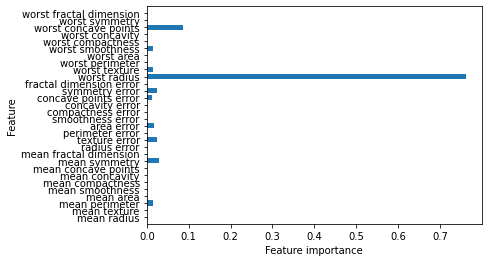

In [8]:
# DECISION TREE MODEL 1

# Gerar um objeto árvore usando uma semente para resultados reproduzíveis
tree_1 = DecisionTreeClassifier(random_state=seed)

# Fitar o modelo usando o dataset de treino
tree_1.fit(X_train, y_train)

# Prever no dataset de validação
y_pred = tree_1.predict(X_val)

# Calcular e printar métricas
print("Acurácia no conjunto de treino: {:.3f}".format(tree_1.score(X_train, y_train)))
print("Acurácia no conjunto de validação: {:.3f}".format(tree_1.score(X_val, y_val)))
print(classification_report(y_val, y_pred))

print(confusion_matrix(y_val, y_pred))
print("Área sob a curva ROC: {:.3f}".format(roc_auc_score(y_val, y_pred)))

# Plotar importância das features
# Avalia quão importante é cada variável para as decisões que a árvore fornece
# Corresponde a um número entre 0 e 1 para cada feature, onde 0 significa não usada e 1
# "perfeitamente prevê a resposta". A importância das features sempre somam 1
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    
plot_feature_importances_cancer(tree_1)

Já de cara, temos uma acurácia de 100% no dataset de treino e 92,3% no de validação, com um AUC de 0,932! Se você lembrar das aulas anteriores, vai perceber que isto é um claro indicativo de *overfitting*. Isto ocorre porque os valores padrões dos hiperparâmetros não limitam a árvore de crescer indefinidamente, fazendo com que o modelo consiga memorizar perfeitamente todos os pontos do conjunto de treino.

Para evitar isto, podemos usar uma técnica chamada **pre-prunning**, que faz com que a árvore pare de crescer indefinidamente. Existem diferentes maneiras de realizar isto, mas a principal é de limitar o hiperparâmetro ```max_depth```, isto é limitar a profundidade máxima que a árvore pode alcançar.

Vamos construir um outro modelo, mas agora setando ```max_depth = 4```, o que faz com que apenas três questões possam ser dispostas sucessivamente.

Acurácia no conjunto de treino: 0.986
Acurácia no conjunto de validação: 0.929
              precision    recall  f1-score   support

           0       0.89      0.92      0.91        53
           1       0.95      0.93      0.94        88

    accuracy                           0.93       141
   macro avg       0.92      0.93      0.92       141
weighted avg       0.93      0.93      0.93       141

[[49  4]
 [ 6 82]]
Área sob a curva ROC: 0.928


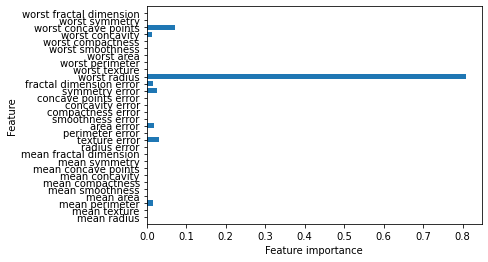

In [9]:
# DECISION TREE MODEL 2

# Gerar um objeto árvore usando uma semente para resultados reproduzíveis
tree_2 = DecisionTreeClassifier(random_state=seed, max_depth=4)

# Fitar o modelo usando o dataset de treino
tree_2.fit(X_train,y_train)

# Prever no dataset de validação
y_pred = tree_2.predict(X_val)

# Calcular e printar métricas
print("Acurácia no conjunto de treino: {:.3f}".format(tree_2.score(X_train, y_train)))
print("Acurácia no conjunto de validação: {:.3f}".format(tree_2.score(X_val, y_val)))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print("Área sob a curva ROC: {:.3f}".format(roc_auc_score(y_val, y_pred)))

# Plotar importância das variáveis
plot_feature_importances_cancer(tree_2)

Vemos que o novo conjunto de hiperparâmetros diminui tanto a acurácia do conjunto de treino quanto de validação. Porém a diferença notável é que ambos estão mais próximos, indicando um modelo menos sobreajustado (overfitted), ou seja, a performance em dados já vistos é um pouco mais similar à performance em dados novos.

É possível melhorar ainda mais a performance? Podemos manualmente tentar diferentes combinações e escolher aquela que garante a melhor métrica. Porém isto é lento e não escalável. Para ajudar nesta tarefa, existem técnicas automáticas como o *grid-search* (busca em grade) para encontrar o melhor conjunto de valores de hiperparâmetros.

In [10]:
# DECISION TREE MODEL 3 (com GridSearch)

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Definir os possiveis valores para cada hiperparametro para serem explorados
params = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
          'min_samples_split': [2, 3, 4, 5, 6],
          'min_samples_leaf': [1, 2, 3]}

# Criar objeto com o DecisionTreeClassifier
tree_3 = DecisionTreeClassifier(random_state=seed)

# Criar objeto KFold com StratifiedKFold para validação cruzada
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

# Criar um objeto de grade de busca com GridSearchCV
grid_search = GridSearchCV(tree_3, param_grid=params, scoring='roc_auc',
                           cv=skf.split(X_training, y_training))

# Treinar o modelo com o grid search
grid_search.fit(X_training, y_training)

# Printar a melhor combinação de hiperparâmetros
print('Melhores hiperparâmetros:')
print(grid_search.best_params_)

Melhores hiperparâmetros:
{'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 2}


Acurácia no conjunto de treino: 0.972
Acurácia no conjunto de validação: 0.943
              precision    recall  f1-score   support

           0       0.91      0.94      0.93        53
           1       0.97      0.94      0.95        88

    accuracy                           0.94       141
   macro avg       0.94      0.94      0.94       141
weighted avg       0.94      0.94      0.94       141

[[50  3]
 [ 5 83]]
Área sob a curva ROC: 0.943


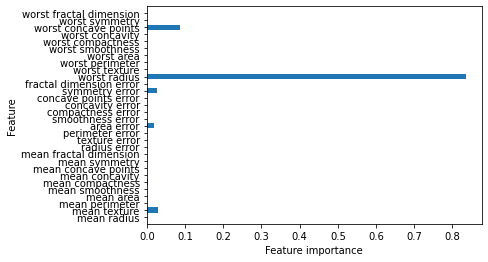

In [11]:
# Gera uma árvore com as melhores combinações de hiperparâmetros
tree_3 = DecisionTreeClassifier(random_state=seed, max_depth=grid_search.best_params_['max_depth'],
                                min_samples_split=grid_search.best_params_['min_samples_split'],
                                min_samples_leaf=grid_search.best_params_['min_samples_leaf'])

# Fita o modelo com o dataset de treino
tree_3.fit(X_train, y_train)

# Usa o modelo para prever o conjunto de validação
y_pred = tree_3.predict(X_val)

# Calcular e printar métricas
print("Acurácia no conjunto de treino: {:.3f}".format(tree_3.score(X_train, y_train)))
print("Acurácia no conjunto de validação: {:.3f}".format(tree_3.score(X_val, y_val)))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print("Área sob a curva ROC: {:.3f}".format(roc_auc_score(y_val, y_pred)))

# Plotar importância das variáveis
plot_feature_importances_cancer(tree_3)

Vemos que usando Grid Search, o hiperparâmetro ```min_samples_leaf``` foi alteardo de 1 para 3 automaticamente, o que proporcionou melhores métricas para o modelo final.

### 5.2. Regressão Logística

#### 5.2.1. Teoria
Regressão logística é um método estatístico para prever classes binárias. O resultado do modelo pode ser interpretado como uma probabilidade da amostra corresponder à classe positiva.

O modelo é uma ligeira modificação da regressão linear onde a variável resposta é categórica em natureza e o output é passado por uma função logística.

**Equação da Regressão Logística**
<center>
$y = \beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2}+ ... + \beta_{n}x_{n}$
</center>

Onde $y$ é a variável dependente (ou resposta) e $x_1$, $x_2$ ... até $x_n$ são as variáveis independentes (ou explanatórias).

<br>

**Função Sigmoide/Logística**
<center>
$p = \frac{1}{1+e^{-y}}$
</center>

Aplicando a função sigmoide na regressão linear, obtêm-se a regressão logística:
<center>
$p = \frac{1}{1+e^{-(\beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2}+ ... + \beta_{n}x_{n})}}$
</center>

**Regressão Linear x Regressão Logística**

Ao passo que a variável resposta da regressão linear não tem restrição de valores, a regressão logística tem sua saída limitada entre 0 e 1. Desta maneira, enquanto a primeira é interessante para problemas como previsão de preço de casas, a segunda é útil para problemas de classificação, onde a variável resposta pode ser interpretada como uma probabilidade (no caso do dataset em questão nesta aula, a probabilidade de que um câncer seja maligno). 

**Vantagens**

Dado sua natureza simples e eficiente, não necessita poder computacional muito grande, é de fácil implementação, altamente interpretável e portanto é muito utilizada.

**Desvantagens**

Não consegue lidar com uma quantidade muito grande de variáveis categóricas. É vulnerável ao overfitting. Não lida com relações não-lineares entre variável explanatória e variável resposta. Não performa bem com features altamente correlacionadas entre si.

#### 5.2.2. Código em Python e Avaliação

In [12]:
from sklearn.linear_model import LogisticRegression

# Treino do modelo
# O otimizador 'liblinear' é utilizado para um conjunto de dados pequeno
logreg = LogisticRegression(solver='liblinear').fit(X_train, y_train)
print("Acurácia no conjunto de treino: {:.3f}".format(logreg.score(X_train, y_train)))
print("Acurácia no conjunto de validação: {:.3f}".format(logreg.score(X_val, y_val)))

Acurácia no conjunto de treino: 0.958
Acurácia no conjunto de validação: 0.950


Olhando para as métricas, a Regressão Logística performa muito bem para esta tarefa.

In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_val, logreg.predict(X_val)))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93        53
           1       0.96      0.97      0.96        88

    accuracy                           0.95       141
   macro avg       0.95      0.95      0.95       141
weighted avg       0.95      0.95      0.95       141



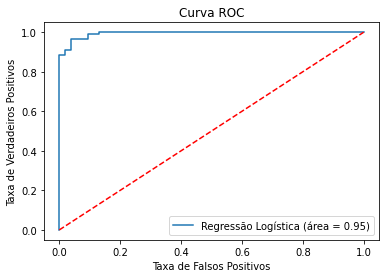

In [14]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

logit_roc_auc = roc_auc_score(y_val, logreg.predict(X_val))
fpr, tpr, thresholds = roc_curve(y_val, logreg.predict_proba(X_val)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Regressão Logística (área = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Regularização é um processo de adição de informação (penalidade) em funções de custo/perda de forma a evitar o overfitting na aprendizagem do modelo. Na regressão logística, o hiperparâmetro que controla a força da regularização é chamado C, e valores maiores correspondem a menos regularização.

Em outras palavras, quando se usa altos valores do hiperparâmetro C, a regressão logística tenta fitar o dataset de treino o melhor possível, independente da magnitude que seus parâmetros adquiram; já com valores baixos de C, o modelo é penalizado por valores altos de parâmetros aprendidos.

<center>

![alt](https://cdn.analyticsvidhya.com/wp-content/uploads/2017/06/Qc281.jpg)


Limiares de decisão para diferentes valores de C
</center>

A imagem à esquerda corresponde ao limiar de decisão (conjunto de pontos onde o modelo indica uma probabilidade igual de ser tanto da classe positiva quanto da negativa) do modelo ao ser treinado com uma alta regularização (portanto, um valor baixo de C). É possível ver um underfitting uma vez que o modelo não é capaz de captar o padrão curvo das amostras positivas no espaço das variáveis, resultando em várias previsões erradas.

A imagem da direita corresponde ao limiar de decisão do modelo ao ser treinado com uma baixa regularização (portanto, um alto valor de C). Neste caso, o overfitting ocorre claramente, pois o modelo tenta delinear perfeitamente todos os pontos, sendo sujeito ao ruído e variância dos dados.

O valor padrão de C=1 já fornece uma boa performance com uma acurácia de aproximadamente 95% em ambos os conjuntos de treino e validação. Vamos verificar o comportamento do modelo ao alterar este hiperparâmetro.

In [15]:
logreg10 = LogisticRegression(C=100).fit(X_train, y_train)
print("Acurácia no conjunto de treino: {:.3f}".format(logreg10.score(X_train, y_train)))
print("Acurácia no conjunto de validação: {:.3f}".format(logreg10.score(X_val, y_val)))

Acurácia no conjunto de treino: 0.951
Acurácia no conjunto de validação: 0.957


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [16]:
print(classification_report(y_val, logreg10.predict(X_val)))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        53
           1       0.97      0.97      0.97        88

    accuracy                           0.96       141
   macro avg       0.95      0.95      0.95       141
weighted avg       0.96      0.96      0.96       141



Com um C=100 não vemos uma diferença significativa nos resultados, o que indica que diminuir ainda mais a regularização (aumentar a complexidade do modelo) não deve ajudar.

Vamos agora investigar o que ocorre ao aumentar a regularização (diminuir C) e consequentemente diminuir a complexidade do modelo:

In [17]:
logreg001 = LogisticRegression(C=0.01,solver='liblinear').fit(X_train, y_train)
print("Acurácia no conjunto de treino: {:.3f}".format(logreg001.score(X_train, y_train)))
print("Acurácia no conjunto de validação: {:.3f}".format(logreg001.score(X_val, y_val)))

Acurácia no conjunto de treino: 0.951
Acurácia no conjunto de validação: 0.936


Vemos uma queda na acurácia do conjunto de validação, o que indica um pequeno underfit.

Como a busca manual pelo melhor valor do hiperparâmetro C seria muito trabalhosa, podemos novamente usar novamente o ```GriSeachCV```.

In [ ]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# Generate a range with different values for C parameter
grid = {"C": np.arange(1,150,5)}

logreg_cv = GridSearchCV(LogisticRegression(solver='liblinear'), grid, cv=10)
logreg_cv.fit(X_train, y_train)

print("Melhores hiperparâmetros: ", logreg_cv.best_params_)
print("Acurácia:", logreg_cv.best_score_)

De quem é essa acurácia retornada pelo Grid Search?

In [ ]:
logreg16 = LogisticRegression(C=16,solver='liblinear').fit(X_train, y_train)
print("Acurácia no conjunto de treino: {:.3f}".format(logreg16.score(X_train, y_train)))
print("Acurácia no conjunto de validação: {:.3f}".format(logreg16.score(X_val, y_val)))

### 5.3. Métodos Compostos (*Ensemble Methods*)

#### 5.3.1. Teoria

Métodos Compostos, como o nome sugere, são métodos em que são combinados diferentes modelos mais simples (*weak learners*) para produzir um modelo de maior capacidade preditiva (*strong learner*). Pensando no universo das árvores de decisão, o principio por trás desses métodos é o de que a união de diversas árvores menores possui uma capacidade preditiva melhor que uma grande árvore (mais complexa).

Para entender um pouco melhor este principio, é importante conhecer o *trade off* entre o viés e a variância:

> **Viés (*bias*)**: É a tendência de o modelo aprender consistentemente uma generalização incorreta. Em outras palavras, o modelo não consegue capturar as relações corretas entre as variáveis e o objeto a ser predito. Portanto, quando o viés é alto o modelo não consegue aprender (*underfitting*).

> **Variância**: A variância é a sensibilidade de um modelo ao ser usado com outros datasets diferentes do treinamento. Se o modelo é muito sensível aos dados de treinamento, ou seja, identificou tão bem a relação entre os dados de treinamento que quando colocado em teste irá errar justamente a variação que existe entre os datasets.

De maneira mais didática, podemos ilustrar estes conceitos com as imagens abaixo:

<center>
    
![alt](https://miro.medium.com/max/914/1*1kOlhkPVgb5upFUaRYbjIQ.png)

   
</center>
Combinação entre o viés e a variancia

<center>
    
![alt](https://miro.medium.com/max/1560/1*Ah1N6gqkA0zZfpSoS9erAA.png)

Predições com alto viés e alta variância
</center>

Dessa forma, nota-se que um bom modelo deve performar com um baixo viés e uma baixa variância, ou seja, ser capaz de identificar e generalizar padrões.

Modelos muito simples, com baixa complexidade são mais sucetiveis a apresentarem um alto viés, ou seja, não aprenderem as relações existentes nos dados. Por outro lado, modelos consideravelmente complexos (muitas variaveis preditoras ou árvores de decisão extensas) podem gerar resultados com alta variância, ou seja, podem aprender padrões que podem não ser reais e consequentemente não apresentar uma capacidade de generalização. Esse trade-off entre a variância e o viés é representado na imagem abaixo:

<center>
    
![alt](https://miro.medium.com/max/490/0*UDp6phojWvlixHO9)

*Trade-off* entre o viés (*bias*) e variancia
</center>

Nota-se que o erro total do modelo é soma do viés com a variância e que conforme o modelo vai “aprendendo” (model complexity aumenta) temos um momento de baixa e logo depois o erro volta a crescer.

É muito comum modelos que aprendem muito bem no conjunto de treino, mas acabam apresentando *Overfitting*. Isso faz com que o modelo esteja do lado direito desse diagrama, entretanto, o ideal é que fique mais próximo ao meio. Então para diminuir a variância acrescentamos um pouquinhos de viés, assim ele “desaprende” o suficiente para conseguir generalizar e ser usado além dos dados de treino.

Retornando à questão inicial da seção, este *trade-off* ilustra que aumentar a complexidade de um modelo pode implicar em uma perda de performance de predição. Portanto, quando temos diversas variaveis a disposição, por exemplo, utilizar uma unica árvore de decisão pode gerar um modelo excessivamente complexo. 

Nesse sentido, os métodos compostos (*ensemble methods*) buscam combinar modelos mais simples (também conhecidos como *base models*) para construir um modelo composto com melhor capacidade de predição. Cada *base model* possui certas especificidades que o fazem performar melhor sob determinadas circunstâncias. No momento em que combinamos estes modelos (que por serem simples demais podem não performar bem por si mesmos) passamos a cobrir uma maior variedade de situações, explorando as vantagens de cada *base model* e complementando seus eventuais pontos de fragilidade. A ideia é similar a utilizar pequenas peças (*base models*) para construir um modelo composto muito mais robusto (*strong learner*) 

As três principais formas de gerar os modelos compostos são: 

> **Bagging**: Método em que são combinados *weak learners* (normalmente homogêneos, mesmo algoritmo), organizados de maneira paralela e independente, sendo o *output* final determinado por um processo de ponderação dos *outputs* de cada *learner*.
<center>
    
![alt](https://miro.medium.com/max/3630/1*7XVde-bMixpKf8mj61qhJQ@2x.png)

   
</center>

> **Boosting**:  Método em que são combinados *weak learners* (normalmente homogêneos, mesmo algoritmo), organizados de maneira sequêncial e adaptativa, ou seja, cada *learner* é escolhido de modo a compensar os eventuais erros do anterior, sendo combinados de uma maneira deterministica para produzir o *output* final.
<center>
    
![alt](https://miro.medium.com/max/3630/1*VGSoqefx3Rz5Pws6qpLwOQ@2x.png)

</center>
    
> **Stacking**: Método em que são combinados *weak learners* (normalmente heterogêneos, algoritmos diferentes), organizados de maneira paralela, de modo que seus *outputs* são utilizados para treinar um meta-modelo que finalmente produz o *output* final.
<center>
    
![alt](https://miro.medium.com/max/700/1*ZucZsXkOwrpY2XaPh6teRw@2x.png)

 </center>

A escolha do método a ser utilizado depende da especificidade do problema e da relação entre as variáveis e o objeto a ser predito. Em geral, testam-se os diferentes algoritmos e escolhe-se aquele que apresentou a melhor performance e capacidade de generalização. Caso queira complementar o aprendizado, recomenda-se a leitura dos artigos:  [1](https://medium.com/ml-research-lab/ensemble-learning-the-heart-of-machine-learning-b4f59a5f9777),[2](https://towardsdatascience.com/ensemble-methods-in-machine-learning-what-are-they-and-why-use-them-68ec3f9fef5f), [3](https://towardsdatascience.com/basic-ensemble-learning-random-forest-adaboost-gradient-boosting-step-by-step-explained-95d49d1e2725#:~:text=Random%20forest%20is%20an,tree%20as%20the%20individual%20model.)
<center>
    
![alt](https://miro.medium.com/max/700/1*P0ns6A56MtpGFMQ2g47IYA.png)

 </center>

Os diferentes métodos de composição são a base de alguns dos modelos mais utilizados na indústria. O algoritmo de *Random Forest*, por exemplo, utiliza o método de *Bagging*, enquanto o *AdaBoost* e o *XGBoost* utilizam o método de *Boosting*. 

Na próxima seção iremos utilizar o *XGBoost (Extreme Gradient Boosting)* para tentar resolver o nosso problema de diagnóstico, portanto, é importante que o conceito de *boosting* seja bem compreendido. No video abaixo explora-se um pouco mais no detalhe este método:

[![IMAGE ALT TEXT](http://img.youtube.com/vi/GM3CDQfQ4sw/0.jpg)](http://www.youtube.com/watch?v=GM3CDQfQ4sw "Decision Tree 1: how it works")

Caso queira se aprofundar ainda mais, assista a esses outros vídeos: [1](https://www.youtube.com/watch?v=ErDgauqnTHk) ou [2](https://www.youtube.com/watch?v=jxuNLH5dXCs).


#### 5.3.2. Código em Python e Avaliação

O primeiro passo a se fazer é instalar a biblioteca do xgboost.

In [20]:
import sys
!{sys.executable} -m pip install xgboost

Em seguida, importamos o modelo junto com algumas métricas de avaliação.

In [21]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

Vamos então treinar nosso primeiro modelo de xgboost.

As etapas básicas são:
- Criar um objeto modelo xgboost com seus hiperparâmetros (como estamos tratando de um problema de classificação, usaremos o ```XGBClassifier```). Você pode ver todos os hiperparâmetros disponíveis [aqui](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier) e mais detalhes sobre cada um deles [aqui](https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster).
- Usar o método ```.fit()``` para treinar o modelo.
- Usar o método ```.predict()``` para usar o modelo para prever novos dados.

Alguns hiperparâmetros importantes que usaremos nessa aula são:
- **objective \[default=reg:squarederror\]**: define o tipo de problema e a função objetivo a ser usada
- **eval_metric \[default according to objective\]**: métrica de avaliação a ser usada junto com o conjunto de validação
- **colsample_bytree \[default=1\]**: percentual de colunas a ser usado em cada árvore
- **learning_rate \[default=0.3\]**: tamanho do passo de atualização no aprendizado
- **max_depth \[default=6\]**: máxima profundidade de cada árvore
- **alpha \[default=0\]**: termo de regularização L1 nos pesos (quanto maior, mais regularização)
- **n_estimators \[default=100\]**: número de árvores para treinar

Vamos primeiramente definir apenas ```objective``` e ```eval_metric``` de forma que o modelo seja treinado com o restante dos hiperparâmetros em seus valores padrão.

Acurácia no conjunto de treino: 1.000
Acurácia no conjunto de validação: 0.957
              precision    recall  f1-score   support

           0       0.93      0.96      0.94        53
           1       0.98      0.95      0.97        88

    accuracy                           0.96       141
   macro avg       0.95      0.96      0.95       141
weighted avg       0.96      0.96      0.96       141

[[51  2]
 [ 4 84]]
Área abaixo da curva ROC: 0.958


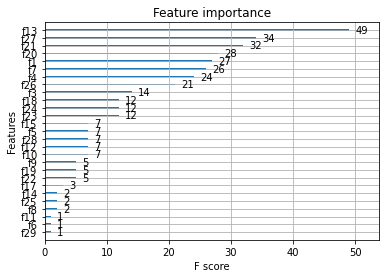

In [22]:
# XGBoost 1

# Criar um objeto XGBClassifier
xgb_model_1 = xgb.XGBClassifier(objective="binary:logistic", random_state=seed, eval_metric="auc",use_label_encoder=False)

# Treinar o modelo usando o conjunto de treino
xgb_model_1.fit(X_train,y_train)

# Prever usando o conjunto de validação
y_pred = xgb_model_1.predict(X_val)

# Calcular e printar algumas métricas
print("Acurácia no conjunto de treino: {:.3f}".format(xgb_model_1.score(X_train, y_train)))
print("Acurácia no conjunto de validação: {:.3f}".format(xgb_model_1.score(X_val, y_val)))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print("Área abaixo da curva ROC: {:.3f}".format(roc_auc_score(y_val, y_pred)))

# Plotar a importância das variáveis
xgb.plot_importance(xgb_model_1)
plt.show()

Como podemos ver, o modelo obteve acurácia de 100% no dataset de treino e 95,7% no dataset de validação, indicando um overfit no treino, embora ainda sim com ótima performance no segundo.

Vejamos agora como usar a Cross Validation com o XGBoost. As principais diferenças do que acabamos de fazer são:
- Criar uma ```DMatrix```, estrutura de dados interna para o xgboost que otimiza a memória usada e velocidade de treino
- Usar o ```StratifiedKFold``` para criar os grupos para a validação cruzada, passando o número de splits ```n_splits```
- Usar o método ```xgb.cv``` para realizar a validação cruzada. Internamente, isto é realizado a cada iteração de boosting, portanto também é retornado o número ótimo de árvores.

AUC média no dataset de treino: 1.000 +/- 0.000
AUC média no dataset de teste: 0.990 +/- 0.007


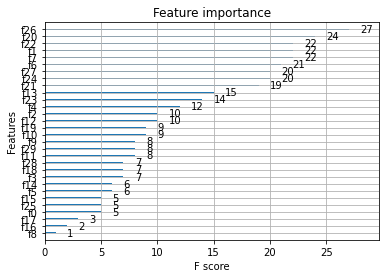

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
42,0.999947,0.000043,0.989753,0.006610
43,0.999947,0.000043,0.989895,0.006705
44,0.999965,0.000050,0.989895,0.006875
45,0.999965,0.000050,0.990001,0.006733
46,0.999965,0.000050,0.990071,0.006752


In [23]:
# XGBoost with Cross Validation

from sklearn.model_selection import StratifiedKFold

# Criar a DMatrix
data_dmatrix = xgb.DMatrix(data=X_training, label=y_training)

# Criar modelo com o XGBClassifier
xgb_model_cv = xgb.XGBClassifier(objective="binary:logistic", random_state=seed, eval_metric="auc",
                                 colsample_bytree=0.3, learning_rate=0.1, max_depth=4, alpha=5, n_estimators=10,use_label_encoder=False)

# Salvar parâmetros em uma variável
params = xgb_model_cv.get_xgb_params()

# Criar objeto StratifiedKFold e rodar validação cruzada
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, folds=skf, num_boost_round=5000,
                    early_stopping_rounds=10, metrics="auc", stratified=True, seed=seed)

# Ajustar o melhor número de árvores em n_estimators
xgb_model_cv.set_params(n_estimators=cv_results.shape[0])

# Treinar o modelo com os datasets de treino + validação
xgb_model_cv.fit(X_training, y_training)

# Printar a AUC média nos datasets de treino e teste
print("AUC média no dataset de treino: {:.3f} +/- {:.3f}".format(cv_results.loc[cv_results.shape[0]-1, 'train-auc-mean'],
                                                                 cv_results.loc[cv_results.shape[0]-1, 'train-auc-std']))
print("AUC média no dataset de teste: {:.3f} +/- {:.3f}".format(cv_results.loc[cv_results.shape[0]-1, 'test-auc-mean'],
                                                                cv_results.loc[cv_results.shape[0]-1, 'test-auc-std']))

# Plotar importância das variáveis
xgb.plot_importance(xgb_model_cv)
plt.show()

# Mostrar as últimas iterações da validação cruzada
cv_results.tail()

Em seguida, vamos realizar o grid search para encontrar o melhor conjunto de valores para os hiperparâmetros.


 Melhores hiperparâmetros:
{'alpha': 5, 'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 3}
Acurácia média no conjunto de validação: 0.987 +/- 0.009


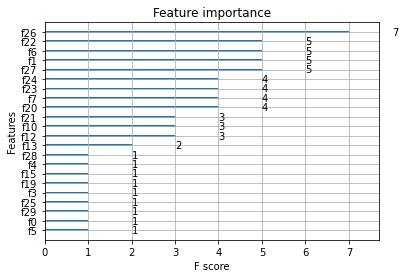

In [24]:
# XGBoost com Cross Validation

from sklearn.model_selection import GridSearchCV

# Define um conjunto de possíveis valores para os hiperparâmetros
params = {'learning_rate': [0.1, 0.2, 0.3],
          'alpha': [5, 10, 15],
          'colsample_bytree': [0.1, 0.3, 0.5, 0.7, 1.0],
          'max_depth': [3, 4, 5]}

# Cria o modelo
xgb_model_cv_gs = xgb.XGBClassifier(objective="binary:logistic", random_state=seed,
                                    eval_metric="auc", n_estimators=10,use_label_encoder=False)

# Cria o grid search com validação cruzada estratificada
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
grid_search = GridSearchCV(xgb_model_cv_gs, param_grid=params, scoring='roc_auc',
                           cv=skf.split(X_training, y_training))

# Treina o modelo e printa os melhores hiperparâmetros
grid_search.fit(X_training, y_training)
print('\n Melhores hiperparâmetros:')
print(grid_search.best_params_)

# Obtém os resultados da validação cruzada
cv_results = pd.DataFrame(grid_search.cv_results_)
print("Acurácia média no conjunto de validação: {:.3f} +/- {:.3f}".format(
  cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0],
  cv_results[cv_results.rank_test_score == 1].std_test_score.values[0])
)

# Atribui os melhores valores para os hiperparâmetros
xgb_model_cv_gs.set_params(learning_rate = grid_search.best_params_['learning_rate'],
                           alpha = grid_search.best_params_['alpha'],
                           colsample_bytree = grid_search.best_params_['colsample_bytree'],
                           max_depth = grid_search.best_params_['max_depth'])

# Treina o modelo usando os melhores hiperparâmetros
xgb_model_cv_gs.fit(X_training, y_training)

# Plota a importância das variáveis
xgb.plot_importance(xgb_model_cv_gs)
plt.show()

Tudo muito legal! Só não entendi muito bem a seleção do algoritmo de base para o XGBoost. Pela definição do atributo `objective`, parece que foi escolhido uma regressão logística. Porém, outros atributos, como `colsample_bytree` e `max_depth` indicam que há uma DT. 

Será que estes dois modelos são utilizados em conjunto? Ou o XGBoost tem um funcionamento baseado em árvore e o `objective` não define o algoritmo de base, mas sim o resultado esperado? Fica a dúvida.

<a id="eval"></a>
## 6. Avaliação dos Modelos

#### Exercício 6.1 

Baseado na AUC de todos os modelos treinados, qual você escolheria como seu classificador final?

In [25]:
AUC_Arvore  = roc_auc_score(y_val, tree_3.predict(X_val))
AUC_RegLog  = roc_auc_score(y_val, logreg16.predict(X_val))
AUC_XGBoost = roc_auc_score(y_val, xgb_model_cv_gs.predict(X_val))

print("AUC Arvore: {:.3f}".format(AUC_Arvore))
print("AUC RegLog: {:.3f}".format(AUC_RegLog))
print("AUC XGBoost: {:.3f}".format(AUC_XGBoost))

AUC Arvore: 0.943
AUC RegLog: 0.970
AUC XGBoost: 0.994


Escolheria o XGBoost, visto que é ele que apresenta a maior AUC.

Como falsos positivos e falsos negativos possuem significados reais completamente diferentes, existe sempre um trade-off entre eles. Tende-se normalmente a minimizar mais um em detrimento de outro de acordo com aquilo que vemos que tem mais impacto.

#### Exercício 6.2  

No caso do problema de câncer de mama tratado aqui, sabendo que uma classe positiva (valor 1) é um tecido diagnosticado como benigno. Qual é o significado de um falso positivo? E de um falso negativo?

Um falso positivo indica que um tecido maligno (0) foi classificado como beningo (1). Já um falso negatico significa exatamente o contrário: um tecido benigno (1) foi classificado como maligno (0).

#### Exercício 6.3 

Baseado na resposta anterior, que tipo de erro é preferível minimizar (falsos positivos ou falsos negativos) e por que?

Nesse contexto, falsos negativo fazem com que sejam contabilizados mais tecidos malignos do que realmente existem. Falsos positivos, pelo contrário, fazem com que sejam contabilizados menos tecidos malignos do que de fato existem.

Na primeira situação, o potencial da doença é maximizado pelo diagnóstico. Isso por gerar uma série de problemas, como preocupações excessivas por parte do paciente e até tratamentos desnecessários. Contudo, o segundo cenário minimiza o potencial destrutivo da doença, o que certamente é um caminho mais perigoso: o tratamento pode ser postergado de forma equivocada ou até realizado de forma mais branda que a necessária e, quando for constatado a real dimensão do problema, pode ser tarde demais para remediar.

Portanto, fica claro que é muito mais interessante minimizar os falsos positivos.

#### Exercício 6.4 

Com base na resposta anterior, escolha entre os modelos treinados, aquele que melhor satisfaz sua decisão.

Para este caso, três métricas podem ser avaliadas:
1. **Precisão**, dada por TP / (TP + FN)
2. **Taxa de Verdadeiro Negativo**, ou especificidade, ou ainda *recall da classe negativa*, dada por TNR = TN / (TN + FP)
3. **Taxa de Falso Positivos**, dada por FPR = FP / (FP + TN) ou FPR = 1 - TNR.

Para minimizar os falsos positivos, a precisão e a TNR devem ser maximizadas, ou a FPR deve ser minimizada.

Fazendo uso da precisão, estamos avaliando somente a taxa de sucesso das previsões positivas. Utilizando a TNR ou a FPR, avaliamos a taxa de sucesso ou fracasso, respectivamente, em prever negativos, que é o cerne da questão.


In [26]:
# obter as predições de todos os modelos, para o conjunto de validação
y_pred_dict = {'tree': tree_3.predict(X_test), 
               'logreg': logreg16.predict(X_test),
               'xgb': xgb_model_cv_gs.predict(X_test)}

especificidade = dict()

# calcular a especifidade para cada modelo
for key, y_pred in zip(y_pred_dict.keys(), y_pred_dict.values()):
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()  
  especificidade[key] = tn / (tn + fp)

print(especificidade)

{'tree': 0.8679245283018868, 'logreg': 0.9056603773584906, 'xgb': 0.9245283018867925}


Podemos observar, novamente, que o XGBoost fornece a maior especificidade. Sendo assim, além de melhor AUC, ele também é o que apresenta menor indice de falsos positivos. Portanto, com certeza é o melhor modelo a ser escolhido para minimizar os falsos positivos.

Aqui vamos apresentar uma possível solução.

Por um lado, se tivermos um falso positivo, estamos diagnosticando um tecido maligno como benigno. Isto é, estamos dizendo ao paciente que está tudo bem, enquanto na verdade não está. Neste caso, a pessoa vai provavelmente postergar um diagnóstico futuro, o que pode fazer com que a doença piore e que o tratamento seja mais drástico.

De outro lado, se tivermos um falso negativo, estamos diagnosticando um tecido benigno como maligno. Em outras palavras, estamos dizendo ao paciente que ele está com câncer, quando na verdade não está. Neste caso, a pessoa sofrerá problemas de ansiedade, tendo um impacto negativo na sua saúde mental, e também estará sujeito a tratamentos como biopsia, em que uma parte ou todo o tecido será removido.

Decidir que tipo de erro é uma questão delicada. Mas aqui focaremos em minimizar a quantidade de falsos positivos. Isto é, queremos maximizar a **precisão** (*precision*), ou seja, maximizar a taxa de acerto quando prevemos que o paciente tem um tecido maligno.

<img src=https://cdn-images-1.medium.com/max/1200/1*uR09zTlPgIj5PvMYJZScVg.png width=500/>

In [27]:
from sklearn.metrics import precision_score

# Realizar as previsões no dataset de teste
y_tree_pred   = tree_3.predict(X_test)
y_logreg_pred = logreg_cv.best_estimator_.predict(X_test)
y_xgb_pred    = xgb_model_cv_gs.predict(X_test)

# Printar a precisão de cada algoritmo
print(precision_score(y_test, y_tree_pred))
print(precision_score(y_test, y_logreg_pred))
print(precision_score(y_test, y_xgb_pred))

0.9247311827956989
0.9456521739130435
0.9555555555555556


Como a regressão logística e o modelo XGBoost dão performances similares, podemos usar outro critério de desempate. Se o modelo precisa rodar o mais rápido possível, poderíamos avaliar o tempo que cada um deles demora para realizar a classificação (em um diagnóstico médico, pode não fazer tanta diferença se os resultados ficarem prontos em 0,10 ou 0,15 segundos, mas isto pode com certeza fazer diferença para aplicações como carros autônomos).

Se for necessário, por exemplo, a aprovação de um diretor para implementar o modelo desenvolvido, pode ser mais interessante o uso de um algoritmo que seja facilmente explanável e interpretável de forma que ele possa entender como o modelo está tomando as decisões. Isto é o que chamamos de **interpretabilidade de modelos**, e é considerado uma questão importante no momento em que um cientista de dados está reportando seus resultados a pessoas que não domimam muito o assunto.

#### Exercício 6.5

Para este exercício, você vai seguir as instruções fornecidas e preencher os campos para construir seus próprios modelos e escolher entre o melhor deles. Para isso, usaremos dados de doadores prévios de sangue para prever quem doará novamente em Março de 2007. O dataset se chama *transfusion.csv*. Ele consiste de:
- Recency: meses desde a última doação
- Frequency: número total de doações antes de Março de 2007
- "Monetary": valor total de sangue doado
- Time: meses desde a primeira doação
- donated: variável resposta binária indicando se a pessoa doou sangue em Março de 2007 (1 = doou, 0 = não doou)

**Obs.:** este é um dataset mais "real" no sentindo em que os pontos não são facilmente separáveis por um modelo. Desta forma, em alguns algoritmos, variar os hiperparâmetros pode não ter uma influência significativa na performance. Sinta-se a vontade para brincar com as variáveis e fazer feature engineering e selection.

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
import numpy as np

data = np.genfromtxt('/content/drive/MyDrive/Programa Ciência de Dados/Entrega 4 - Classificacao/Dados/transfusion.csv', delimiter=';', skip_header=1)

X (748, 4)
y (748,)


##### Feature engineering

In [426]:
trans = pd.DataFrame(data).rename(columns={
    0:'Recency',
    1:'Frequency',
    2:'Monetary',
    3:'Time',
    4:'Donated'
})

In [353]:
trans[['Donated']].value_counts(normalize=True)

Donated
0.0        0.762032
1.0        0.237968
dtype: float64

Percebemos que a classe está bem desbalanceada. Portanto, a utilização de técnicas de validação cruzada estratificada é uma abordagem a ser considerada.

In [132]:
trans.head(2)

,Recency,Frequency,Monetary,Time,Donated
0,2.0,50.0,12500.0,98.0,1.0
1,0.0,13.0,3250.0,28.0,1.0


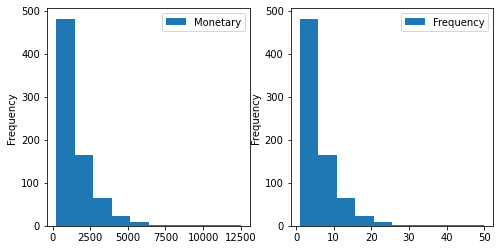

In [130]:
fig, axs = plt.subplots(1, 2)

trans[['Monetary']].plot.hist(ax=axs[0])
trans[['Frequency']].plot.hist(ax=axs[1])

fig.set_size_inches(8,4)

In [134]:
np.unique(trans.Monetary / trans.Frequency)

array([250.])

Percebe-se também que a Frequency e a Monetary são diretamente proporcionais, e a proporção é de 250. Ou seja, o doador recebe um valor de 250 para cada doação que realiza.

Sendo assim, uma das duas variáveis não precisa estar presente no dataset, visto que tem exatamente mesmo compontamento.

In [427]:
trans = trans.drop('Monetary', axis=1)

Além disso, as variáveis Frequency e Time não dizem muita coisa sozinhas. 

Por exemplo, um paciente que começou a doar há pouco tempo (Time baixo) provavelmente doou poucas vezes (Frequency baixo). Já uma paciente que começou há mais tempo (Time mais alto), pode ter doado um número maior de vezes (Frequency mais alto). 

Analisando estas duas variáveis isoladas, pode parecer que o segundo paciente está mais propenso a uma nova doação do que o primeiro.

Contudo, o paciente que doa há pouco tempo pode estar sendo mais aitvo do que o que doa há mais tempo. Essa atividade pode ser medida pela frequência em relação ao tempo, dada por Activity = Frequency / (Time - Recency).

Considerando esta nova variável, pode-se concluir que o primeiro paciente, mais ativo, tem mais chace de doar novamente do que o segundo paciente. Portanto, cabe trocar a variávei Frequency pela variável Activity.

In [428]:
Activity = trans.Frequency / (trans.Time - trans.Recency)
Activity

0      0.520833
1      0.464286
2      0.470588
3      0.465116
4      0.315789
         ...   
743    0.133333
744    0.064516
745    0.076923
746         inf
747         inf
Length: 748, dtype: float64

Ao calcular a variável Activity, obtivemos alguns valores inf. Isto ocorre pois devem haver casos em que as variáveis Time e Recency tem o mesmo valor, ou em que a variáveis Frequency é zero. Vamos chamar este grupo de pacientes de G1.

In [161]:
print('Qtd de valores inf em Acticity: {:d}'.format(Activity[Activity == float('inf')].size))

g1 = trans[trans.Time == trans.Recency]
print('Qtd de amostras em que Time = Recency: {:d}'.format(g1.iloc[:, 0].size))

Qtd de valores inf em Acticity: 192
Qtd de amostras em que Time = Recency: 192


In [162]:
g1.Frequency.unique().astype('int')

array([4, 2, 1, 5])

Nestas amostras temos, portanto, pacientes que doaram pela última vez no mesmo mês em que iniciaram as doações. Cursiosamente, alguns desses pacientes doram mais de uma vez (até 5!), aparentemente no mesmo mês.

In [164]:
g1[['Donated']].value_counts(normalize=True)

Donated
0.0        0.864583
1.0        0.135417
dtype: float64

Este grupo de pacientes apresenta chance de repetir a doação em Março de 2017 consideravelmente menor. Enquanto a porcentagem dos que repetiram a doações ficou em 23,8%, no G1 ela caiu para 13,54%. Ou seja, os pacientes deste grupo tendem a doar menos que os demais.

In [186]:
trans[['Recency', 'Frequency', 'Donated']][(trans.Time == trans.Recency)].groupby(['Donated', 'Frequency']).count()

Recency
Donated Frequency         
0.0     1.0            138
        2.0             26
        4.0              1
        5.0              1
1.0     1.0             20
        2.0              5
        4.0              1

In [354]:
trans[['Donated']][(trans.Time == trans.Recency) & (trans.Recency > 4)].value_counts(normalize=False)

Donated
0.0        102
1.0          7
dtype: int64

Entre os pacientes do G1 que doaram a 5 meses ou mais, probabilidade de repetição da doação cai ainda mais: 6,42%!. Contudo, este subgrupo representa apenas 56,77% do total.

Mesmo assim, pode-se dizer que a probabilidade dos pacientes do G1 realizarem uma nova doação é baixa. Portanto, faz sentido que a Activity deles também seja baixa. 

Portanto, substituiremos os valores inf de Activity por 0.

In [429]:
Activity.replace(float('inf'), 0, inplace=True)

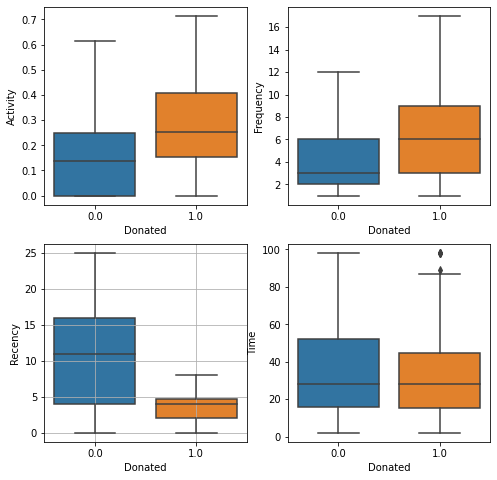

In [430]:
import seaborn as sns

trans2 = trans.copy()
trans2['Activity'] = Activity

fig, axs = plt.subplots(2,2)

sns.boxplot(y='Activity', x='Donated', data=trans2, ax=axs[0][0], showfliers=False)
sns.boxplot(y='Frequency', x='Donated', data=trans2, ax=axs[0][1], showfliers=False)
sns.boxplot(y='Recency', x='Donated', data=trans2, ax=axs[1][0], showfliers=False)
sns.boxplot(y='Time', x='Donated', data=trans2, ax=axs[1][1], showfliers=True)

axs[1][0].grid(True)

fig.set_size_inches(8,8)
plt.show()

Pelos gráficos, podemos perceber que:
* A variável Recency parece boa para a previsão: se está abaixo de 5, há maior chance de positivos.
* A variável Time, contudo, é péssima para previsão: seu comportamento é muito parecido para ambos os casos, positivo e negativo.
* As variáveis Frequency e Activity tem um comportamento semelhante, no sentido de que o terceiro quartil dos casos negativos tem interseção com o primeiro quartil dos casos positivos. Além disso, tem compostamentos distintos para os casos positivo e negativo

Portanto, a variável Time pode ser desconsiderada.

In [431]:
trans2.drop('Time', axis=1, inplace=True)

In [432]:
trans2[trans2.Recency <= 5][['Donated']].value_counts(normalize=True)

Donated
0.0        0.627072
1.0        0.372928
dtype: float64

Ainda, observa-se que a variável Recency, isolada, também não é um bom indicativo para prever a doação futura. 

Alguns doadores de sangue mantém uma periodicidade nas doações, ou seja, fazem uma doação a cada X meses. O valor médio desta periodicidade pode ser dado pelo inverso da Activity ((Time - Recency) / Frequency). Cabe avaliar, portanto, se o intervalo de tempo entre a data de análise, Março de 2007, e a data da última doação (Recency) corresponde à periodicidade do paciente.

In [433]:
Period = 1 / trans2.Activity
trans2[(Period <= trans2.Recency + 5) & (Period >= trans2.Recency - 5)][['Donated']].value_counts(normalize=True)

Donated
0.0        0.58042
1.0        0.41958
dtype: float64

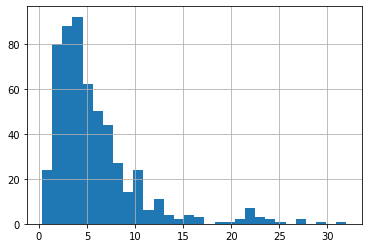

In [400]:
Period[Period != float('inf')].hist(bins=30)

Na célula a seguir, complete o código para realizar o split treino, validação e teste.

In [420]:
# Separar a variável resposta
X = np.delete(data, -1, 1)
y = data[:, [-1]].ravel()

print("X", X.shape)
print("y", y.shape)

X (748, 4)
y (748,)


In [562]:
X = trans2[['Recency', 'Activity']].values
y = trans[['Donated']].values

In [564]:
from sklearn.model_selection import train_test_split

seed = 1

#Construa os Datasets de Treino e Teste
X_training, X_test, y_training, y_test = train_test_split(X, y, random_state=seed, test_size=0.25, stratify=y)

print("Conjunto de teste X", X_test.shape)
print("Conjunto de teste y", y_test.shape)

#Construa o Dataset de Validação
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, random_state=seed,
                         test_size=0.33, stratify=y_training)

print("Conjunto de treino X", X_train.shape)
print("Conjunto de treino y", y_train.shape)
print("Conjunto de validação X", X_val.shape)
print("Conjunto de validação y", y_val.shape)

Conjunto de teste X (187, 2)
Conjunto de teste y (187, 1)
Conjunto de treino X (375, 2)
Conjunto de treino y (375, 1)
Conjunto de validação X (186, 2)
Conjunto de validação y (186, 1)


##### DT

Agora, use a célula abaixo para treinar uma árvore de decisão. Brinque com os hiperparâmetros para ver a influência de cada um na performance final. Atente-se para as métricas de avaliação para evitar o overfit.

Acurácia no conjunto de treino: 0.803
Acurácia no conjunto de validação: 0.780
              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86       142
         1.0       0.54      0.43      0.48        44

    accuracy                           0.78       186
   macro avg       0.69      0.66      0.67       186
weighted avg       0.77      0.78      0.77       186

[[126  16]
 [ 25  19]]
AUC: 0.660


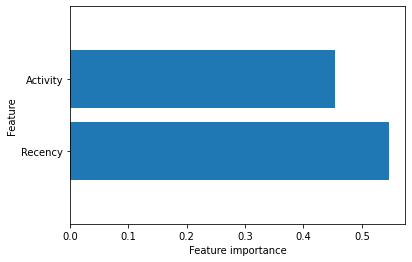

In [567]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score

# Árvore de decisão

# Gerar um objeto árvore
tree = DecisionTreeClassifier(
    random_state=seed, 
    max_depth=3, 
    min_samples_split=2,
    min_samples_leaf=1)

# Fitar o modelo usando o dataset de treino
tree.fit(X_train, y_train)

# Prever no dataset de validação
y_pred_tree = tree.predict(X_val)

# Calcular e printar métricas
print("Acurácia no conjunto de treino: {:.3f}".format(tree.score(X_train, y_train)))
print("Acurácia no conjunto de validação: {:.3f}".format(tree.score(X_val, y_val)))
print(classification_report(y_val, y_pred_tree))
print(confusion_matrix(y_val, y_pred_tree))
print("AUC: {:.3f}".format(roc_auc_score(y_val, y_pred_tree)))

def plot_feature_importances_cancer(model):
    n_features = 2
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), ['Recency', 'Activity', 'Frequency'])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    
plot_feature_importances_cancer(tree)

Em teste manuais na mesma célula, percebeu-se que a alteração de nenhum dos três hiperparâmetros experimentados teve efeito significativo sobre o valor da acurácia ou da AUC. Portanto, não vale a pena fazer uma investigação mais profunda com o Grid Search.

##### RegLog

Construa agora um modelo de regressão logística, tentando diferentes hiperparâmetros.

In [540]:
# Regressão logística

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1)

logreg.fit(X_train, y_train)

y_pred_logreg = logreg.predict(X_val)

print("Acurácia no dataset de treino: {:.3f}".format(logreg.score(X_train, y_train)))
print("Acurácia no dataset de validação: {:.3f}".format(logreg.score(X_val, y_val)))
print(classification_report(y_val, y_pred_logreg))
print(confusion_matrix(y_val, y_pred_tree))
print("AUC: {:.3f}".format(roc_auc_score(y_val, y_pred_tree)))

Acurácia no dataset de treino: 0.771
Acurácia no dataset de validação: 0.763
              precision    recall  f1-score   support

         0.0       0.77      0.98      0.86       142
         1.0       0.50      0.07      0.12        44

    accuracy                           0.76       186
   macro avg       0.64      0.52      0.49       186
weighted avg       0.71      0.76      0.69       186

[[126  16]
 [ 25  19]]
AUC: 0.660


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Aqui, também verificou-se que a alteração do hiperparâmetro de regularização (C) não foi afetiva na otimização das métricas de acurácia e AUC. Portanto, não cabe a utilização do Search Grid.

##### XGBoost

Como último modelo, treine um XGBoost, novamente alterando os hiperparâmetros e avaliando seu efeito.

In [530]:
# XGBOOST
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=seed, eval_metric="auc", use_label_encoder=False,
                              colsample_bytree=1, learning_rate=0.2, max_depth=3, alpha=5, n_estimators=10)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_val)

print("Acurácia no dataset de treino: {:.3f}".format(xgb_model.score(X_train, y_train)))
print("Acurácia no dataset de validação: {:.3f}".format(xgb_model.score(X_val, y_val)))
print(classification_report(y_val, y_pred_xgb))
print(confusion_matrix(y_val, y_pred_xgb))
print("AUC: {:.3f}".format(roc_auc_score(y_val, y_pred_xgb)))

Acurácia no dataset de treino: 0.811
Acurácia no dataset de validação: 0.790
              precision    recall  f1-score   support

         0.0       0.82      0.94      0.87       142
         1.0       0.61      0.32      0.42        44

    accuracy                           0.79       186
   macro avg       0.71      0.63      0.65       186
weighted avg       0.77      0.79      0.76       186

[[133   9]
 [ 30  14]]
AUC: 0.627


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Para o XGBoost, a alteração dos hiperparâmetros `max_depth` e `colsample_bytree` de 4 para 6 e de 0.3 para 1.0, respectivamente, foram as alterações que otimizaram as métricas de avaliação. 

Mesmo assim, apesar de termos uma acurácia de 80% para o dataset de validação, temos uma AUC muito baixa, de 0.627, o que indica que o modelo ainda erra bastante. De fato, analisando a matriz de confusão, notamos que o recall é bem baixo: 0.30. Ou seja, o modelo apresenta alto índice de falsos negativos.

Avalie todos os modelos construídos no dataset de teste e escolha aquele que melhor performa de acordo com sua métrica de avalição escolhida (não há necessidade de manter a métrica usada. Sinta-se livre para escolher qualquer outra). Explique brevemente a razão da escolha da métrica.

##### Avaliação

Do ponto de vista do banco de sangue, uma projeção pessimista (com excesso de falsos negativos) podem trazer tanta dor de cabeça quanto uma projeção demais otimista (com muitos falsos positivos). No primeiro caso, poderia haver esforçoes desnecessário em camapanhas publicitárias, por exemplo, resultado em gastos excessivos. No último caso, a dispinibilidade de sangue no banco ao final do período avaliado seria menor do que a esperada, prejudicando as projeções do banco para utilização do sange coletado.

Sendo assim, seria interessante minimizar ambos os erros do modelo: falsos negativos e falsos positivos. Utilizaremos, portanto, a métrica que nos fornece uma avaliação do índice de acertos das previsões, sem considerar o tipo de erro: a acurácia. 

In [38]:
#Defina a métrica e avalie os modelos
print("Acurácia do DT: {:.3f}".format(tree.score(X_val, y_val)))
print("Acurácia da RegLog: {:.3f}".format(logreg.score(X_val, y_val)))
print("Acurácia do XGBoost: {:.3f}".format(xgb_model.score(X_val, y_val)))

Acurácia do DT: 0.785
Acurácia da RegLog: 0.780
Acurácia do XGBoost: 0.801


Novamente, é o XGBoost quem apresenta a melhor métrica de avaliação e, consequentemente, ele seria o modelo escolhido para essa aplicação.

<a id="multiclass"></a>
## 7. Classificação Multiclasse

### 7.1. Definição do Problema

Primeiramente, cabe distinguirmos os conceitos de classificação multiclasse e multirótulo (multilabel).

* **Classificação multiclasse** corresponde a uma classificação em mais de duas classes. Exemplos: classificar um conjunto de imagem de frutas que podem ser laranjas, maçãs ou peras. Classificação multiclasse assume que cada amostra pertence a uma e apenas uma classe (isto é, são mutualmente excludentes). Uma laranja não pode ser uma pera ao mesmo tempo.

* **Classificação multilabel** atribui a cada amostra um conjunto diferente de rótulos. Isto pode ser pensado como prever propriedades de um ponto de dado que não sejam mutualmente excludentes. Exemplos: gêneros de filmes e tópicos de um documento. Um filme pode ser tanto comédia como romance e um texto pode falar tanto sobre política quanto sobre educação.

Muitos dos algoritmos usados para classificação binária também servem para classificação multiclasse (e também para tarefas de regressão).

Outros algoritmos, como Suport Vector Machines (SVM) ou preditores lineares (como a regressão logística), são estritamente para problemas binários. Entretanto, existem diferentes estratégias para realizar uma classificação multiclasse com preditores binários.

* Um contra todos (One-Versus-All) é uma estratégia em que um classificador é treinado para cada classe no dataset (a classe correspondente é tratada como positiva e todas as outras, negativas). Então, a amostra é fornecida como input para todos os classificadores e aquele que retorna a maior probabilidade é escolhido como previsão.

* Um contra um (One-Versus-One) é uma estratégia que treina diferentes modelos para cada par de classes. Desta forma, se existem N classes, são necessários, $\frac{N(N-1)}{2}$ preditores. Uma das vantagens é que cada classificador precisa apenas ser treinado em um subconjunto do dataset de treino. Para a previsão, todos os $\frac{N(N-1)}{2}$ são utilizados e a classe com a maior quantidade de previsões positivas é tomada como a previsão final.

A grande vantagem do ```scikitlearn``` é que ele detecta quando tenta-se usar um classificador binário para uma tarefa multiclasse. Neste caso, usa-se automáticamente a estratégia OvA (exceto para o algoritmo SVM)

### 7.2. Código

Para treinar nosso estimador multiclasse, vamos usar o dataset MNIST, que contém imagens de dígitos numéricos de 0 a 9 escritos a mão.

Este conjunto de dados é largamente conhecido e utilizado. O objetivo é prever o digito a partir da imagem fornecida.

<center>

![MNIST](https://miro.medium.com/max/584/1*2lSjt9YKJn9sxK7DSeGDyw.jpeg)

</center>

In [39]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()

X_train, X_test, y_train, y_test = train_test_split(
  digits.data, digits.target, stratify=digits.target, random_state=42
)

Note que as imagens tem dimensão 8x8 pixels, o que corresponde a 64 variáveis/features diferentes (onde cada pixel é uma variável independente diferente). E quanto maior o valor da variável, mais claro é o tom daquele pixel.

[[ 0.  0.  0.  8. 12.  1.  0.  0.]
 [ 0.  0.  1. 15. 12.  1.  0.  0.]
 [ 0.  0.  6. 16.  3.  0.  0.  0.]
 [ 0.  0.  7. 16.  1.  0.  0.  0.]
 [ 0.  1. 16. 16. 14.  5.  0.  0.]
 [ 0.  1. 12. 16.  6. 14.  9.  0.]
 [ 0.  0.  2. 16.  6. 10. 15.  0.]
 [ 0.  0.  0.  6. 16. 16. 11.  0.]]


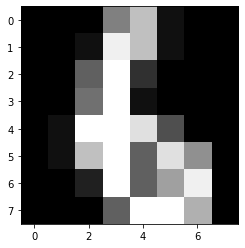

In [40]:
import matplotlib.pyplot as plt

%matplotlib inline

# Mostrar exemplo de amostra
print(X_test[5].reshape(8, -1))
_ = plt.imshow(X_test[5].reshape(8, -1), cmap='gray')

Inicialmente usaremos um modelo linear chamado SGD, que utiliza como treinamento o método de gradiente descendente (o mesmo usado para treinar redes neurais), mas a escolha pode ser qualquer outra.

In [41]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [42]:
# Testar uma previsão
print('Resposta: ', y_test[5])
print('Previsão: ', sgd_clf.predict(X_test[5].reshape(1,-1))[0])

Resposta:  6
Previsão:  6


Simples, não? O código já encapsula e abstrai todo a implementação da estratégia de classificação multiclasse usando um preditor binário. Por trás do treino, a biblioteca do ```scikit-learn``` treinou 10 modelos diferentes e os usou para realizar a previsão.

Você pode usar a função ```decision_function()``` para retornar todos os scores da previsão das 10 classes.

In [43]:
digit_score = sgd_clf.decision_function(X_test[5].reshape(1, -1))
digit_score

array([[-6742.120961  ,  -447.94292282, -2433.29785652, -2155.72020851,
        -2140.16728557, -3803.14479006,  1175.23077843, -4393.05258444,
        -1151.87377463, -3802.06363924]])

Nele é possível ver que o maior score realmente pertence à classe 6.

Caso deseje forçar o ```scikitlearn``` a usar uma estratégia ou outra, você pode usar as classes ```OneVsOneClassifier``` ou ```OneVsRestClassifier```.

Basta criar uma instância da classe que implementa a estratégia desejada passando um preditor binário como argumento do método construtor da classe. Abaixo um exemplo que cria um classificador multiclasse usando a estratégia OvO e o preditor SGD.

In [44]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict(X_test[5].reshape(1, -1))
len(ovo_clf.estimators_)

45

Podemos ver que o número de estimadores treinados corresponde à formula

$\frac{(10(10-1))}{2}$ = 45

Vamos agora treinar um modelo de floresta aleatória (random forest)


In [45]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)
forest_clf.predict(X_test[5].reshape(1, -1))

array([6])

Neste caso, como o Random Forest é um algoritmo que implementa a classificação multiclasse por natureza, não há a necessidade de rodar uma das estratégias OvA ou OvO. 

Você pode chamar a função ```predict_proba()``` para obter a lista de probabilidades que o classificador atribuiu para cada instância e cada classe.

In [46]:
forest_clf.predict_proba(X_test[5].reshape(1, -1))

array([[0.  , 0.04, 0.01, 0.01, 0.01, 0.03, 0.87, 0.  , 0.02, 0.01]])

Podemos ver que o preditor é suficientemente confiante de sua previsão, atribuindo aproximadamente 90% de probabilidade da amostra ser um dígito 6.

### 7.3. Avaliação do Modelo

Agora, podemos analisar a performance do preditor usando as funções ```cross_val_score()``` e ```confusion_matrix()```

In [47]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[132,   0,   0,   0,   0,   1,   0,   0,   0,   0],
       [  0, 125,   1,   3,   2,   0,   1,   0,   3,   1],
       [  0,   1, 129,   0,   0,   0,   0,   0,   2,   1],
       [  0,   0,   0, 127,   0,   3,   0,   2,   4,   1],
       [  0,   3,   0,   0, 131,   0,   0,   1,   1,   0],
       [  0,   2,   0,   1,   1, 128,   1,   1,   0,   2],
       [  0,   1,   0,   0,   0,   1, 134,   0,   0,   0],
       [  0,   0,   0,   2,   1,   0,   0, 129,   1,   1],
       [  0,  10,   0,   8,   0,   0,   1,   0, 112,   0],
       [  0,   4,   0,   8,   0,   1,   0,   3,   4, 115]])

Como estamos tratando com 10 classes, a quantidade de métricas acaba dificultando a visualização. Uma maneira mais visual de avaliar neste caso é vendo a matriz como imagem.

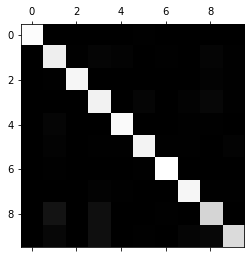

In [48]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

Como a grande maioria dos valores se encontra na diagonal principal, as previsões estão corretas e pode-se concluir que o 
desempenho do modelo está bom.

#### Exercício 7.1

Implemente um modelo SVM para a tarefa de multiclassificação e imprima o número de estimadores criados usando a estratégia OvA.

In [49]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier

ova_clf = OneVsOneClassifier(SVC(gamma='auto'))
ova_clf.fit(X_train, y_train)

print(y_test[20])
print(ova_clf.predict(X_test[20].reshape(1, -1))[0])

n_estimadores = len(ova_clf.estimators_)
print(n_estimadores)

9
9
45


___

<a id="digdeeper"></a>
## 8. Dig Deeper

* [Multi-Class Text Classification with Scikit-Learn](https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f)
* [Music Genre Classification with Python](https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8)
* [XGBoost Algorithm: Long May She Reign!](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d)
* [Fine-tuning XGBoost in Python like a boss](https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e)
* [An interesting and intuitive view of AUC and ROC curve](https://towardsdatascience.com/an-interesting-and-intuitive-view-of-auc-5f6498d87328)

In [50]:
# LEMBRE-SE DE SALVAR O NOTEBOOK ANTES DE EXECUTAR ESSA CÉLULA
token = '<SEU TOKEN AQUI>' # seu token aqui
 
# Não altere o código 	abaixo
import requests as req
exec(req.get('https://api.vai.academy/submissioncode').text)

KeyboardInterrupt: ignored